## HuggingFace로 MNLI 해결하는 모델 학습하기

이번 실습에서는 HuggingFace로 MNLI.
즉, 주어진 전제에 대해 가설이 참인지 거짓인지, 혹은 무관한지 판단과 같은 text 분류 문제를 위한 모델을 구현합니다.

먼저 필요한 library들을 설치하고 import합니다.


In [ ]:
!pip install transformers datasets evaluate accelerate scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import random
import evaluate
import numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score

##Dataset 준비
그 다음 텍스트 분석을 위해 사용할 nyu-mll/glue dataset을 `load_dataset` 함수로 다운로드 받습니다.

load_dataset
HuggingFace의 datasets library의 함수, HuggingFace의 hub에서 dataset을 다운로드 받을 수 있도록 만든 함수입니다.

##학습 데이터셋 (train)
구성 : premise(전제), hypothesis(가설), label(레이블), idx(인덱스)

##검증 데이터셋 (validation)
matched / mismatched

##테스트 데이터셋 (test)
matched / mismatched

이 중 본 과정에서는 train과 test 데이터를 활용할 예정

In [ ]:
dataset = load_dataset("nyu-mll/glue", "mnli")
dataset

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/52.2M [00:00<?, ?B/s]

(…)alidation_matched-00000-of-00001.parquet:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

(…)dation_mismatched-00000-of-00001.parquet:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

test_matched-00000-of-00001.parquet:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

test_mismatched-00000-of-00001.parquet:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test_matched split:   0%|          | 0/9796 [00:00<?, ? examples/s]

Generating test_mismatched split:   0%|          | 0/9847 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})

### train 데이터 나누기



dataset의 각 data는 features와 num_rows로 구성되어있습니다.

---
* 코드 추가 설명

데이터셋에서 train 부분만 사용해서 train/validation을 나누었습니다.
-> 요구사항에 따라 train split만 사용하고, 그 중 일부를 validation으로 분리합니다.


1. `train_val_split = train_dataset.train_test_split(test_size=0.1, seed=42)`에서 `train_dataset`을 다시 훈련용과 검증용으로 분할합니다.

2. `test_size=0.1`은 전체 데이터의 10%를 검증용(테스트용)으로 사용한다는 의미이고, `seed=42`는 분할 시 일관성을 유지하기 위한 난수 생성 시드값입니다.

3. `train_data = train_val_split["train"]`으로 분할된 데이터 중 훈련용 데이터(90%)를 `train_data` 변수에 저장합니다.

4. `val_data = train_val_split["test"]`로 분할된 데이터 중 검증용 데이터(10%)를 `val_data` 변수에 저장합니다.

---


🧷 **test_size란?**

`test_size=0.1`은 원본 데이터셋에서 테스트 데이터로 분리할 비율을 의미합니다. 이 코드에서는 0.1 즉 10%를 의미하므로, 전체 데이터의 10%가 val_data(테스트 데이터)로 분리되고 나머지 90%는 train_data(학습 데이터)로 할당됩니다.

---
🧷 **seed란?**

데이터 분할 시 사용되는 난수 생성기의 시드값입니다. 이 값을 고정함으로써
실험의 일관성을 유지할 수 있습니다(Reproducibility). 같은 시드값을 사용하면 항상 같은 방식으로 데이터가 분할됩니다.
다른 사람이 코드를 실행해도 동일한 결과를 얻을 수 있습니다.


(+) 시드값은 어떤 숫자든 될 수 있지만, 42는 관례적으로 자주 사용되는 값


In [ ]:
# 나누기 전 전체 데이터
train_dataset = dataset["train"]
print("< BEFORE > 전체 데이터 수 \n", train_dataset)

# 나눈 후 train 데이터수와 test용 데이터 수
train_val_split = train_dataset.train_test_split(test_size=0.1, seed=42)
train_data = train_val_split["train"]
val_data = train_val_split["test"] # 나뉜 데이터수

print("\n\n< AFTER > 나눈 후 전체 데이터 수 및 나눠진 train 데이터 수 : \n", train_val_split)

< BEFORE > 전체 데이터 수 
 Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx'],
    num_rows: 392702
})


< AFTER > 나눈 후 전체 데이터 수 및 나눠진 train 데이터 수 : 
 DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 353431
    })
    test: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 39271
    })
})


---

`train data`를 [0]을 통해 한 번 더 살펴보겠습니다.

이전에 확인했듯 `tain`과 `test`의 각 데이터는 `primise`, `hypothesis`, `label`, `idx`로 구성되어 있습니다.

In [ ]:
dataset['train'][0]

{'premise': 'Conceptually cream skimming has two basic dimensions - product and geography.',
 'hypothesis': 'Product and geography are what make cream skimming work. ',
 'label': 1,
 'idx': 0}

##Tokenizer 설정
: tokenizer로 text들을 tokenizing합니다.

###tokenizer 모델별 결과 확인

-> 너무 느려 `distilbert-base-uncased`로 학습 진행. 추후 하단의 다른 모델들과 결과 비교해보아야 함.

1.   bert-base-uncased


2.   roberta-base


3.   xlnet-base-cased


In [ ]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

### Premise와 Hypothesis 변환

자연어 추론(NLI) 태스크에서는 두 개의 문장(premise와 hypothesis)을 입력으로 받습니다.

이 때, 모델은 이 텍스트를 그대로 처리할 수 없고, 숫자 형태로 변환된 token 이라는 단위로 처리합니다.

In [ ]:
def preprocess_function(examples):

    # premise와 hypothesis를 결합해 입력으로 사용
    return tokenizer(
        examples["premise"],
        examples["hypothesis"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

* `truncation=True` 생략시

기본값은 truncation=False
문장이 모델의 최대 길이(예: 512 토큰)보다 길면 오류🚫가 발생합니다.
긴 문장을 처리할 때 중요한 정보가 잘릴 위험 없이 전체 문장을 사용할 수 있지만, 최대 길이를 초과하면 처리가 불가능❌ 합니다.


*   `padding="max_length"` 생략시

각 예제 길이가 다름 -> 학습시 에러가 발생할 가능성이 높습니다.
Pytorch는 배치 내 모든 텐서가 동일한 크기여야합니다.
`padding=True`로 대체시 배치 내에서만 가장 긴 시퀀스에 맞춰 패딩됩니다.

*   `max_length=128` 생략시

토크나이저의 기본 최대 길이가 사용됩니다(일반적으로 512).

더 긴 시퀀스를 처리할 수 있지만, 메모리 사용량이 증가하고 학습 속도가 느려집니다.



---

### 데이터셋에 전처리 적용
`map` 메소드를 사용하여 데이터셋의 모든 예시에 한 번에 그룹으로 묶어(=배치 처리함) 적용.



In [ ]:
tokenized_train = train_data.map(preprocess_function, batched=True)
tokenized_val = val_data.map(preprocess_function, batched=True)

Map:   0%|          | 0/353431 [00:00<?, ? examples/s]

Map:   0%|          | 0/39271 [00:00<?, ? examples/s]

### 모델 로드
3개 클래스(entailment, neutral, contradiction)를 분류하는 모델을 로드합니다.

* 오류 메세지로 뜨는 아래의 경고문은 새로 초기화된 부분이 있으니 모델을 학습시켜야 한다는 정보성 경고. *무시하고 넘어가도 됨.*
```
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
```

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=3
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 평가 메트릭 설정
정확도를 평가 지표로 사용합니다.

***   `evaluate.load("accuracy")`**

HuggingFace의 evaluate 라이브러리에서 accuracy 매트릭(특정 수치들을 그래프로 보여주는 일종의 시각화) 도구를 로드합니다.




***   `predictions`**

각 클래스에 대한 확률값 형태.
`np.argmax(predictions, axis=1)`로 가장 확률이 높은 클래스 인덱스로 변환합니다.

*** `metric.compute()`**

예측과 실제 레이블 간의 정확도를 계산

---
📎 F1이란?
📎 predictions, labels = eval_pred  # 예측값과 실제값
  predictions = np.argmax(predictions, axis=1)  # 가장 높은 확률의 클래스 선택
  코드 이해가 필요함..

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred # 예측값과 실제값
    predictions = np.argmax(predictions, axis=1) # 가장 높은 확률의 클래스 선택

    # 정확도와 가중 F1 스코어 - 분류 문제 평가에 적합
    accuracy = accuracy_score(labels, predictions) # 정확도 계산
    f1 = f1_score(labels, predictions, average='weighted') ## 가중 F1 스코어 계산

    return {
        "accuracy": accuracy,
        "f1": f1
    }

### 학습 관련 파라미터 설정




* `output_dir` : 결과 파일들이 저장될 위치
* `learning_rate` : optimizer가 파라미터를 업데이트하는 스텝 크기
* `per_device_train_batch_size` : 한 번에 처리할 학습 데이터 개수
* `num_train_epochs` : 전체 데이터셋을 몇 번 반복해서 학습할지 -> *시간을 단축하기 위해 2번만 반복. 추후에 얼마나 돌리면 과적합이 될지 실험해보고 싶음.*
* `weight_decay` : 과적합 방지를 위한 L2 정규화 강도
* `evaluation_strategy` : 언제 평가를 수행할지 ("epoch"는 각 에폭 끝에 평가)
* `load_best_model_at_end` : 학습이 끝난 후 최고 성능의 모델을 자동으로 불러올지 여부

---

🧷 optimizer란?

기계학습(machine learning)의 **학습 단계에서 최적의 매개변수를 찾아내는 것이 옵티마이저의 역할**입니다. 여기서 최적이란, 손실 함수가 최솟값이 될 때의 매개변수 값을 의미합니다. 그러나 일반적인 문제의 손실 함수는 매우 복잡합니다. 이런 상황에서 기울기를 잘 이용하여 함수의 최솟값을 찾는 것이 바로 옵티마이저입니다.
  여기서 주의할 점은 각 지점에서 함수의 값을 낮추는 방안을 제시하는 지표가 기울기라는 것입니다. 복잡한 함수에서 기울기가 가리키는 곳이 정말로 나아가야 할 방향인지를 보장할 수 없습니다.
출처 : https://james-scorebook.tistory.com/entry/옵티마이저Optimizer-12


---

🧷 과적합(Over-fitting)이란?

머신 러닝에서 과적합은 알고리즘이 학습 데이터에 과하게 적합한 상태이거나 정확하게 일치할 때 발생하며 그 결과 **모델이 학습 데이터가 아닌 다른 데이터에서 정확한 예측을 생성하거나 결론을 도출할 수 없게 됩니다.** 즉, 새로운 데이터를 효과적으로 일반화할 수 없게 됩니다. 모델이 새로운 데이터를 효과적으로 일반화할 수 없다면 의도한 분류 또는 예측 작업을 수행할 수 없습니다.

낮은 오류율과 높은 분산은 과적합을 나타내는 좋은 지표입니다. 이러한 유형의 동작을 방지하기 위해 일반적으로 학습 데이터 세트의 일부를 '테스트 세트'로 따로 설정하여 과적합 여부를 확인합니다. **학습 데이터의 오류율이 낮고 테스트 데이터의 오류율이 높으면 과적합임을 시사합니다.**

-> 낮추기 위해서 어떻게 해야할까?

과도한 학습 또는 모델 복잡성으로 인해 과적합이 발생하는 경우 논리적 예방 대응은 **학습 과정을 조기 종료하거나 관련성이 낮은 입력을 제거하여 모델의 복잡성을 줄이는 것 입니다.**
출처 : https://www.ibm.com/kr-ko/think/topics/overfitting

---

🧷 L2 정규화(L2 regularization)란?

L2 : 두 점 사이의 최단 거리를 측정할 때 사용됨.

모델의 가중치(weights)의 제곱합에 대한 패널티를 적용함으로써, **모델 가중치의 크기를 가능한 작게 유지하려고 합니다. 각 특성(feature)이 출력에 미치는 영향을 낮게 유지하면서도 모델의 정확도를 최대한 높이는 것이 목적**입니다.

L2 정규화는 특히 대규모의 특성 세트를 다룰 때 유용하며, 모델의 복잡성을 줄이고 과적합을 방지하는 데에 효과적입니다. 그러나 L2 정규화는 특성 선택(feature selection)에는 적합하지 않으며, 이 경우 L1 정규화가 더 자주 사용됩니다. L1 정규화는 중요도가 낮은 특성의 계수를 정확히 0으로 만들어 해당 특성을 모델에서 제외시킬 수 있기 때문입니다.
출처 : https://wikidocs.net/152833


In [ ]:
# 학습 설정
training_args = TrainingArguments(
    output_dir="./results",  # 결과 저장 디렉토리
    learning_rate=3e-5,  # 학습률
    per_device_train_batch_size=16,  # GPU 당 학습 배치 크기
    per_device_eval_batch_size=16,  # GPU 당 평가 배치 크기
    num_train_epochs=1,  # 전체 데이터셋을 1번 반복 # 과적합이 어느 정도 돌리면 나올지 궁금..
    weight_decay=0.01,  # 가중치 감쇠 (과적합 방지)
    evaluation_strategy="epoch",  # 매 에폭마다 평가
    save_strategy="epoch",  # 매 에폭마다 모델 저장
    load_best_model_at_end=True,  # 학습 완료 후 최고 성능 모델 로드
    metric_for_best_model="accuracy",  # 정확도 기준으로 최고 모델 선택
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


### Trainer 객체 생성 - 학습률 관리



In [ ]:
trainer = Trainer(
    model=model,  # 학습할 모델
    args=training_args,  # 학습 설정
    train_dataset=tokenized_train,  # 학습 데이터
    eval_dataset=tokenized_val,  # 검증 데이터
    tokenizer=tokenizer,  # 토크나이저
    compute_metrics=compute_metrics,  # 평가 함수
)

<ipython-input-21-e1148a69eadf>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


### 모델 학습

⏰ 문제 발생.
Colab 사용량 제한, 속도 문제, 런타임 초과로 인해 Epoch 3 -> 2 -> 1 로 줄여 학습을 2일간 진행하였으나 끝내 결과 모델 완성까지 진행되지 못하였습니다.
평가 단계까지 도달하지 못하고 하단의 이미지와 같이 1.82/2만 진행되어 1 epoch의 모델 Training Loss, Validation Loss, Acuuracy, F1만 확인할 수 있었습니다.

**이를 해결하기 위해 크기가 작은 모델 사용, 에포크 감소 등 방법을 써보았지만 현재 노트북에서는 해답을 찾지 못하였습니다.
이를 어떻게 해결하면 되는지 여쭙고 싶습니다. 배치 사이즈를 줄이면 될까요?**

**!! 추후 데스크탑에서 로컬로 실행해 비교해볼 것 !!**

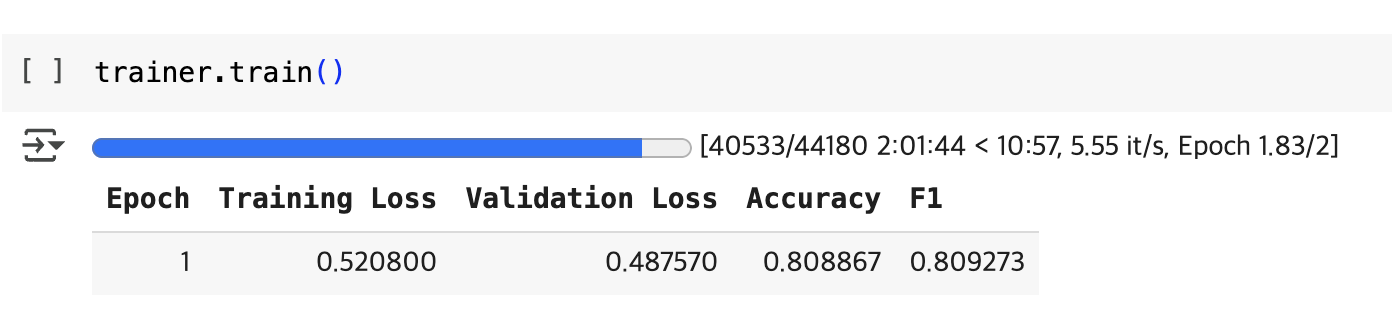

---

###모델 학습 결과
*** 검증 손실이 학습 손실보다 낮습니다.**

 모델이 아직 과적합되지 않았음을 의미합니다.

***정확도와 F1 점수가 모두 약 81%로 상당히 좋은 성능을 보이고 있습니다.**
모델은 현재 약 81%의 정확도로 분류 작업을 수행하고 있으며, 아직 훈련이 완료되지 않았으므로 2epoch까지 진행될 경우 더 높은 성능을 기대할 수 있습니다.

(+)F1 점수는 정밀도와 재현율의 조화 평균. 클래스 불균형이 있는 경우에 더 의미 있는 지표입니다.

***`load_best_model_at_end=True`**
최종적으로는 가장 좋은 성능을 보인 모델이 선택될 것입니다.

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss


### validation_matched로 평가 - 실제 평가 데이터로 성능 측정

In [ ]:
test_dataset = dataset["validation_matched"]  # validation_matched 데이터셋 사용
tokenized_test = test_dataset.map(preprocess_function, batched=True)  # 평가 데이터 전처리
results = trainer.evaluate(tokenized_test)  # 평가 수행